<a href="https://colab.research.google.com/github/asupraja3/ml-ng-notebooks/blob/main/FeatureScaling_and_LearningRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optional Lab: Feature Scaling and Learning Rate (Multi‑variable)

This self‑contained notebook shows:
- How to **scale features** (min‑max, mean normalization, **z‑score**)
- How scaling affects **gradient descent convergence**
- How to choose/tune the **learning rate (α)** with visual diagnostics

Libraries: `numpy`, `matplotlib` (no external datasets required).


In [19]:

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)


## 1) Create a synthetic multi‑feature dataset (house pricing style)

In [20]:
# ---------------------------------------------------------------
# Simulating a house price dataset with multiple features
# ---------------------------------------------------------------

# Features: [size(sqft), bedrooms, age(years), floors]
# Each row in X_train will represent one house with 4 features

rng = np.random.default_rng(0)
# Create a reproducible random number generator using a fixed seed (0)
# Using default_rng (NumPy's recommended random generator) ensures consistent results on every run

m = 300
# Number of samples (rows) in the dataset — here, 300 houses

# ------------------- Feature Generation -----------------------

size = rng.uniform(600, 3500, m)
# Randomly generate house sizes in square feet
# Values are uniformly distributed between 600 and 3500
# This is a large numeric range — suitable for showing the effect of feature scaling later

beds = rng.integers(1, 6, m)
# Randomly assign number of bedrooms (integers from 1 to 5)
# Small integer range — less variation compared to size

age = rng.uniform(0, 40, m)
# Randomly generate the age of the house in years
# Values between 0 (brand new) and 40 years old
# Medium numeric range

floors = rng.integers(1, 4, m)
# Randomly assign number of floors (1 to 3)
# Small integer range — categorical-like numeric feature

# ------------------- Combine into Feature Matrix -----------------------

X_train = np.c_[size, beds, age, floors].astype(float)
# Combine the four feature arrays column-wise into one matrix
# np.c_ stacks arrays as columns → shape becomes (m, 4)
# Casting to float ensures compatibility with mathematical operations in ML algorithms

# ------------------- Define Ground Truth Model -----------------------

true_w = np.array([220.0, 30.0, -2.0, 15.0])
# "True" model weights for each feature (unknown to the learner)
# Interpretation:
#   size(sqft) → +$220 per additional sqft
#   bedrooms   → +$30 per bedroom (small effect, possibly unrealistic in real life)
#   age        → -$2 per year of age (older homes slightly cheaper)
#   floors     → +$15 per additional floor

true_b = 50_000.0
# "True" bias/intercept term → base price when all features are zero

# ------------------- Add Realistic Noise -----------------------

noise = rng.normal(0, 25_000, m)
# Gaussian noise with mean 0 and std deviation 25,000
# Simulates unpredictable real-world factors affecting house prices (location, renovations, etc.)

# ------------------- Generate Target Values -----------------------

y_train = X_train @ true_w + true_b + noise
# Compute target prices:
#   X_train @ true_w   → matrix multiplication (dot product) between features and weights
#   + true_b           → adds the base price
#   + noise            → injects randomness to simulate imperfect predictions

# ------------------- Metadata & Preview -----------------------

X_features = ["size(sqft)", "bedrooms", "age", "floors"]
# Store feature names for readability and later plotting/interpretation

X_train[:3], y_train[:3]
# Preview the first 3 rows of features and corresponding prices
# Helps check data correctness before training



(array([[2447.189,    3.   ,   28.465,    3.   ],
        [1382.381,    5.   ,   33.764,    1.   ],
        [ 718.823,    4.   ,   27.112,    1.   ]]),
 array([605259.805, 340922.811, 197257.442]))

## 2) Visualize feature distributions (before/after scaling)

In [21]:
def norm_plot(ax, x, bins=30):
    """
    Plot a histogram of the data `x` and overlay a normal distribution PDF
    (Probability Density Function) with the same mean and standard deviation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes object to plot on.
    x : array-like
        Input data for which the histogram and normal curve will be drawn.
    bins : int, optional (default=30)
        Number of bins to use for the histogram.

    Returns
    -------
    mu : float
        Mean of the input data.
    sigma : float
        Standard deviation of the input data.
    """

    # ------------------- Compute Statistics -------------------
    mu, sigma = np.mean(x), np.std(x)
    # mu    → average value of the dataset
    # sigma → standard deviation (spread of the data)

    # ------------------- Plot Histogram -------------------
    ax.hist(x, bins=bins, alpha=0.6, density=True)
    # ax.hist(...) draws the histogram on the given Axes `ax`
    # alpha=0.6 → semi-transparent bars
    # density=True → normalize histogram so area under histogram = 1
    # (important so it can be compared with the PDF)

    # ------------------- Prepare Normal Distribution Curve -------------------
    xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    # xs → 200 evenly spaced points covering ±4 standard deviations from the mean
    # This range covers ~99.99% of the normal distribution

    if sigma > 1e-12:
        # Avoid division by zero or extremely tiny sigma values

        # PDF formula for a normal distribution:
        # f(x) = (1 / (σ√(2π))) * exp(-0.5 * ((x - μ) / σ)^2)
        pdf = (1.0 / (sigma * np.sqrt(2 * np.pi))) * \
              np.exp(-0.5 * ((xs - mu) / sigma) ** 2)

        ax.plot(xs, pdf, linewidth=2)
        # Overlay the smooth normal curve on the histogram
        # linewidth=2 → makes the curve stand out

    # ------------------- Beautify the Plot -------------------
    ax.grid(True, alpha=0.3)
    # Adds a light grid for better readability

    return mu, sigma
    # Return the mean and standard deviation for reference

## 3) Scaling utilities (min‑max, mean normalization, z‑score)

In [22]:
def minmax_scale(X):
    """
    Perform Min-Max Scaling on features.
    Formula: X' = (X - X_min) / (X_max - X_min)

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Feature matrix where m = number of samples, n = number of features.

    Returns
    -------
    X_s : ndarray
        Scaled features in range [0, 1] for each column.
    X_min : ndarray
        Minimum values of each feature (before scaling).
    X_max : ndarray
        Maximum values of each feature (before scaling).
    """

    X = X.astype(float)
    # Ensure floating-point division

    X_min = X.min(axis=0)
    # Minimum value per feature (column)

    X_max = X.max(axis=0)
    # Maximum value per feature (column)

    # Avoid division by zero if feature has constant values
    denom = np.where(X_max - X_min == 0, 1.0, X_max - X_min)

    X_s = (X - X_min) / denom
    # Scale each feature so it lies in [0, 1]

    return X_s, X_min, X_max

def mean_normalize(X):
    """
    Perform Mean Normalization.
    Formula: X' = (X - μ) / (X_max - X_min)

    Centers data around mean 0 and scales according to range.

    Returns:
    --------
    X_s : normalized features
    mu : mean values of each feature
    (X_min, X_max) : min and max values for each feature
    """

    X = X.astype(float)
    mu = X.mean(axis=0)
    # Mean value per feature

    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    # Avoid division by zero
    denom = np.where(X_max - X_min == 0, 1.0, X_max - X_min)

    X_s = (X - mu) / denom
    # Shift mean to zero and scale by range

    return X_s, mu, (X_min, X_max)

def zscore_normalize(X):
    """
    Perform Z-Score Normalization (Standardization).
    Formula: X' = (X - μ) / σ

    Centers data at 0 with standard deviation of 1.

    Returns:
    --------
    X_s : standardized features
    mu : mean values of each feature
    sigma : standard deviations of each feature
    """

    X = X.astype(float)
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    # ddof=0 → population standard deviation

    # Avoid division by zero if σ = 0
    sigma = np.where(sigma == 0, 1.0, sigma)

    X_s = (X - mu) / sigma
    # Center around 0, scale to unit variance

    return X_s, mu, sigma

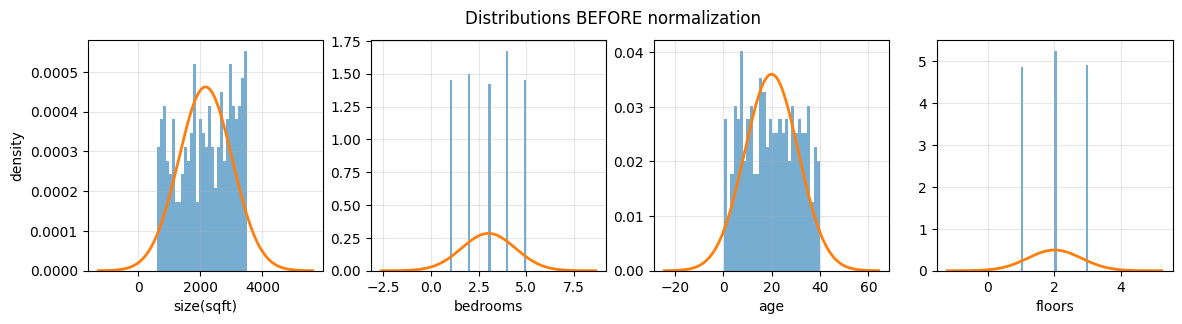

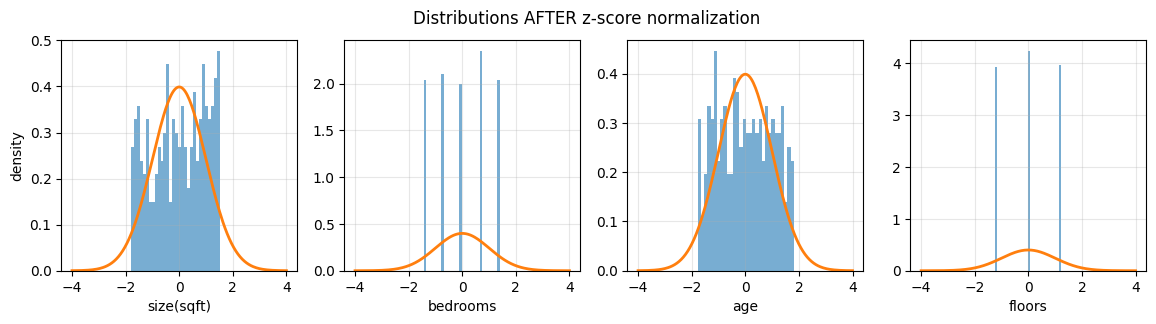

In [23]:
# ------------------- Plot distributions *before* normalization -------------------

fig, ax = plt.subplots(1, X_train.shape[1], figsize=(14, 3))
# Create a row of subplots: 1 row, number of columns = number of features
# figsize=(14, 3) → wide enough to fit all feature histograms in one row
# ax is an array of Axes objects, one for each feature

for i in range(X_train.shape[1]):
    norm_plot(ax[i], X_train[:, i])
    # Call our custom norm_plot() function to plot:
    # - Histogram of feature i
    # - Overlaid normal distribution curve (based on mean/std of that feature)

    ax[i].set_xlabel(X_features[i])
    # Label x-axis with the feature name (e.g., "size(sqft)", "bedrooms")

ax[0].set_ylabel("density")
# Label y-axis for the first subplot (shared meaning across all plots)

fig.suptitle("Distributions BEFORE normalization")
# Add an overall title for the figure

plt.show()
# Display the figure

# Z-score normalize
X_norm, mu, sigma = zscore_normalize(X_train)

# Plot distributions *after* normalization
fig, ax = plt.subplots(1, X_norm.shape[1], figsize=(14, 3))
for i in range(X_norm.shape[1]):
    norm_plot(ax[i], X_norm[:, i])
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("density")
fig.suptitle("Distributions AFTER z-score normalization")
plt.show()


## 4) Linear regression helpers (cost, gradient, GD)

In [24]:
def predict(X, w, b):
    """
    Compute predictions for given inputs using a linear model.

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Input feature matrix.
    w : ndarray, shape (n,)
        Weight vector.
    b : float
        Bias term.

    Returns
    -------
    y_pred : ndarray, shape (m,)
        Predicted values.
    """
    return X @ w + b
    # Matrix multiplication: (m, n) @ (n,) → (m,)
    # Adds bias b to each predicted value
def compute_cost(X, y, w, b):
    """
    Compute Mean Squared Error (MSE) cost function for linear regression.
    Formula: J(w, b) = (1 / (2m)) * Σ (y_pred - y)^2

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Input features.
    y : ndarray, shape (m,)
        True target values.
    w : ndarray, shape (n,)
        Model weights.
    b : float
        Model bias.

    Returns
    -------
    J : float
        Cost value (scalar).
    """
    m = X.shape[0]
    # Number of training examples

    errors = X @ w + b - y
    # Vector of prediction errors → (y_pred - y)

    return (errors @ errors) / (2 * m)
    # Equivalent to np.sum(errors ** 2) / (2*m)
    # Factor 1/(2m) is for convenience in derivative calculations
def compute_gradient(X, y, w, b):
    """
    Compute gradient of the cost function w.r.t. weights and bias.

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Input features.
    y : ndarray, shape (m,)
        True target values.
    w : ndarray, shape (n,)
        Model weights.
    b : float
        Model bias.

    Returns
    -------
    dj_dw : ndarray, shape (n,)
        Gradient of cost w.r.t. each weight.
    dj_db : float
        Gradient of cost w.r.t. bias.
    """
    m = X.shape[0]

    errors = X @ w + b - y
    # Vector of prediction errors (m,)

    dj_dw = (X.T @ errors) / m
    # Gradient for weights: (n, m) @ (m,) → (n,)
    # Average over all training examples

    dj_db = np.sum(errors) / m
    # Gradient for bias: scalar → mean error

    return dj_dw, dj_db
def gradient_descent(X, y, w_init, b_init, alpha, num_iters):
    """
    Perform batch gradient descent to optimize weights and bias.

    Parameters
    ----------
    X : ndarray, shape (m, n)
        Training features.
    y : ndarray, shape (m,)
        Training target values.
    w_init : ndarray, shape (n,)
        Initial weights.
    b_init : float
        Initial bias.
    alpha : float
        Learning rate (step size for updates).
    num_iters : int
        Number of iterations.

    Returns
    -------
    w : ndarray, shape (n,)
        Final optimized weights.
    b : float
        Final optimized bias.
    J_hist : ndarray
        History of cost values over iterations.
    trace : list
        List of (cost, weights, bias) snapshots for the first up-to-1000 iterations
        (useful for visualization/diagnostics).
    """
    w = w_init.copy().astype(float)
    # Make a float copy so original initial weights aren't modified

    b = float(b_init)

    J_hist = []
    # Store cost at each iteration

    trace = []
    # Store diagnostic snapshots for plotting weight/bias changes

    for t in range(1, num_iters + 1):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        # Compute gradients using current weights & bias

        w -= alpha * dj_dw
        # Update weights in the opposite direction of the gradient

        b -= alpha * dj_db
        # Update bias similarly

        J = compute_cost(X, y, w, b)
        # Compute cost after the update (to track learning progress)

        J_hist.append(J)

        if t <= 1000:
            # Store limited history to keep memory usage low
            trace.append((J, w.copy(), b))

    return w, b, np.array(J_hist), trace
    # J_hist → useful for plotting learning curves
    # trace → useful for visualizing optimization path


## 5) Train **without** scaling (expect slow/unstable with same α)

Unscaled   → final cost: 509966139.5235139
Unscaled   → w: [238.826   0.76    3.872   0.494] b: 0.25


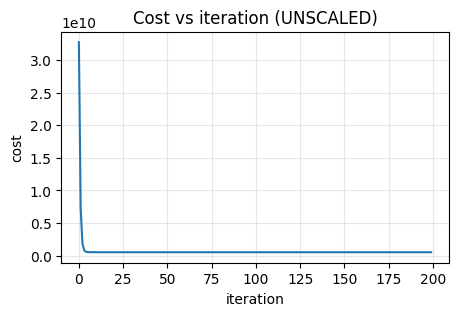

In [25]:
# Start with small random parameters
n = X_train.shape[1]
w0 = np.zeros(n)
b0 = 0.0
# Zero init is fine for linear regression (convex loss); no symmetry issues.

alpha = 1e-7        # Very small step because features are on wildly different scales.
                    # (e.g., size in thousands vs. bedrooms in single digits)
                    # On unscaled data, large alpha often explodes due to poor conditioning.

iters = 200         # Short run; expect *slow* decrease in cost with such a tiny alpha.

w_ns, b_ns, J_ns, tr_ns = gradient_descent(X_train, y_train, w0, b0, alpha, iters)
# Runs batch GD on the raw (unscaled) features. Because the problem is ill-conditioned,
# updates are cautious and convergence is slow. That's intentional here to avoid divergence.

print("Unscaled   → final cost:", J_ns[-1])
print("Unscaled   → w:", w_ns, "b:", round(b_ns, 2))
# Expect weights still far from ground truth after 200 iters with tiny alpha.
# The absolute value of the cost is less important than its *trend* (should be decreasing).

plt.figure(figsize=(5,3))
plt.plot(J_ns)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost vs iteration (UNSCALED)")
plt.grid(True, alpha=0.3)
plt.show()
# Learning curve should slope downward but may be shallow and possibly noisy early on.
# If you see increases/spikes, alpha may still be too high for the unscaled setup.


## 6) Train **with z‑score scaling** (can use a much larger α)

Scaled (z) → final cost: 282734061.37523276
Scaled (z) → w: [186711.74    -639.869  -4430.965   1644.851] b: 525238.8


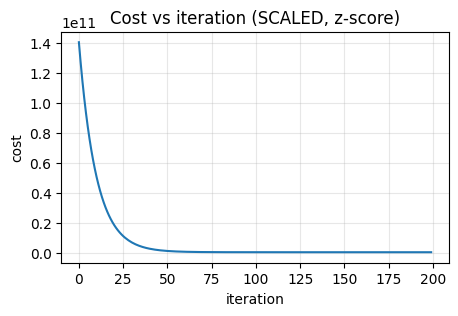

In [26]:
alpha_s = 5e-2      # Larger step works after z-score scaling (features ~ N(0,1))
iters_s = 200       # Fewer iterations are needed when the problem is well-conditioned

w_s, b_s, J_s, tr_s = gradient_descent(X_norm, y_train, w0, b0, alpha_s, iters_s)
# Run batch GD on standardized features.
# Expect fast, smooth decrease in cost if alpha_s is reasonable.

print("Scaled (z) → final cost:", J_s[-1])
print("Scaled (z) → w:", w_s, "b:", round(b_s, 2))
# Note: w_s and b_s are parameters in the *scaled* feature space.

plt.figure(figsize=(5,3))
plt.plot(J_s)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost vs iteration (SCALED, z‑score)")
plt.grid(True, alpha=0.3)
plt.show()
# Learning curve should drop quickly and be roughly monotone.


## 7) Targets vs predictions (using **normalized** model)

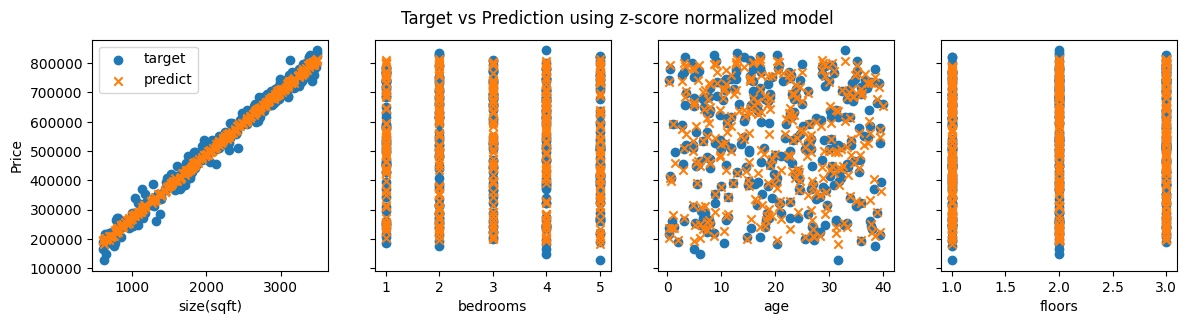

In [27]:
# ------------------- Generate Predictions (using normalized features) -------------------
yp = predict(X_norm, w_s, b_s)
# Predict prices using the model trained on z-score normalized features.
# w_s, b_s are in normalized space — X_norm is the scaled feature matrix.

# ------------------- Create per-feature scatter plots -------------------
fig, ax = plt.subplots(1, X_norm.shape[1], figsize=(14, 3), sharey=True)
# 1 row of subplots, one for each feature
# sharey=True → All subplots share the same price scale (helps compare spread/errors visually)

for i in range(X_norm.shape[1]):
    # Scatter of actual targets vs. original feature values
    ax[i].scatter(X_train[:, i], y_train, label="target")
    # Shows how the true prices change with feature i

    # Scatter of predicted prices vs. original feature values
    ax[i].scatter(X_train[:, i], yp, marker='x', label="predict")
    # 'x' marker differentiates predicted points from actual target points

    ax[i].set_xlabel(X_features[i])
    # Label each subplot's x-axis with the feature name

# Label and legend
ax[0].set_ylabel("Price")
# Only the first subplot gets a y-axis label (shared y)

ax[0].legend()
# Legend for "target" vs "predict" — placed only on first subplot

# Figure title
fig.suptitle("Target vs Prediction using z-score normalized model")

# Render the figure
plt.show()


## 8) Learning rate sweeps & parameter trace diagnostics

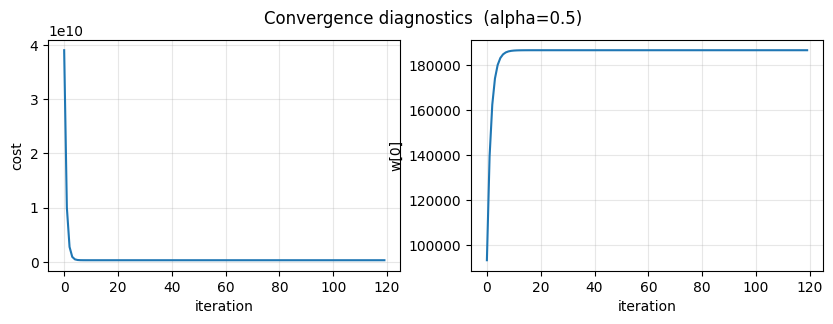

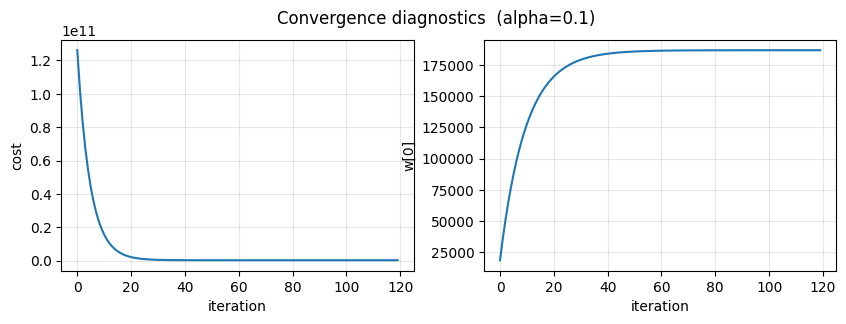

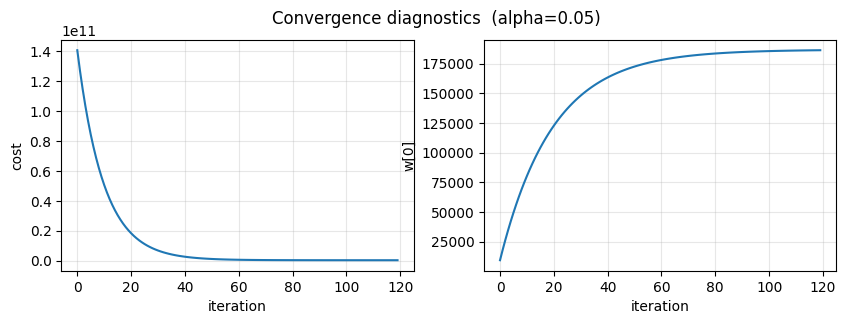

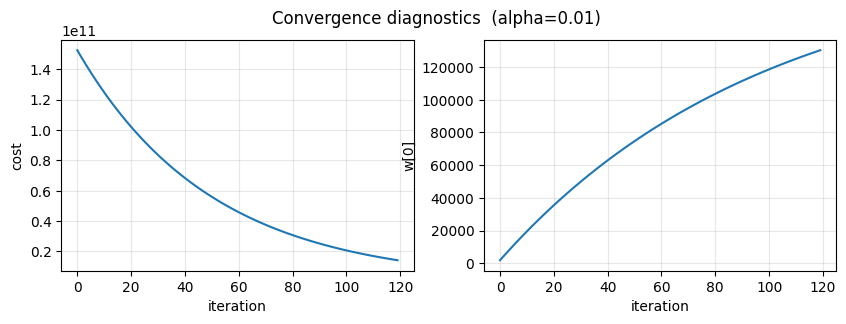

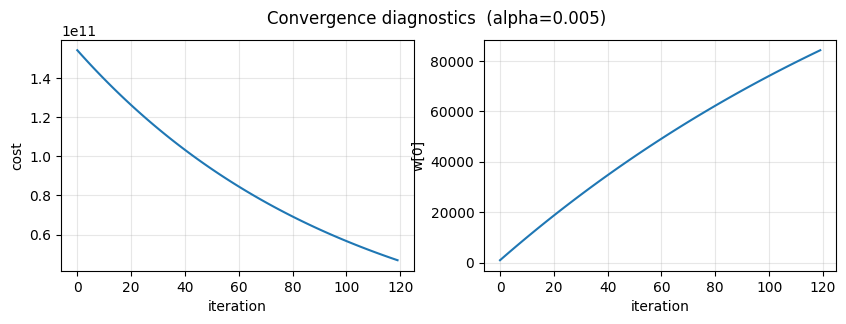

In [28]:
def plot_cost_and_param_trace(trace, param_index=0, title_suffix=""):
    """
    Visualize optimization diagnostics from `trace` captured during gradient descent.
    Left:  cost vs iteration
    Right: evolution of a chosen weight w[param_index] over iterations

    Parameters
    ----------
    trace : list of tuples
        [(J_t, w_t, b_t), ...] for successive iterations (you store up to 1000).
    param_index : int
        Which weight component to plot on the right panel.
    title_suffix : str
        Extra text to append to the figure title (e.g., learning rate).
    """
    # Unpack the per-iteration snapshots from the trace
    J = [t[0] for t in trace]     # cost history
    W = [t[1] for t in trace]     # list of weight vectors
    B = [t[2] for t in trace]     # list of biases (not plotted here)
    w_series = [w[param_index] for w in W]  # the chosen weight over time

    # Build side-by-side plots: cost (left) and weight evolution (right)
    fig = plt.figure(figsize=(10, 3))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(J)
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("cost")
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(w_series)
    ax2.set_xlabel("iteration")
    ax2.set_ylabel(f"w[{param_index}]")
    ax2.grid(True, alpha=0.3)

    fig.suptitle(f"Convergence diagnostics{title_suffix}")
    plt.show()

# Sweep a few learning rates on *standardized* features to compare stability/speed.
alphas = [0.5, 0.1, 0.05, 0.01, 0.005]
iters = 120

for a in alphas:
    # Fresh init each run so curves are comparable
    w0 = np.zeros(X_norm.shape[1])
    b0 = 0.0

    _, _, _, tr = gradient_descent(X_norm, y_train, w0, b0, a, iters)
    plot_cost_and_param_trace(tr, param_index=0, title_suffix=f"  (alpha={a})")


## 9) Optional: Convert normalized weights back to original feature scale

In [29]:

# If the model was trained on z‑score normalized features:
#   y ≈ ( (x - mu)/sigma )·w_s + b_s
# Expand to get: y ≈ x·(w_s / sigma) + (b_s - mu·(w_s / sigma))
w_back = w_s / sigma
b_back = b_s - (mu @ w_back)

print("Recovered weights in ORIGINAL scale:")
print("w_back:", w_back)
print("b_back:", round(b_back, 2))


Recovered weights in ORIGINAL scale:
w_back: [ 216.371 -455.951 -399.51  2040.204]
b_back: 61660.64
